In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dynamic Attention Mechanism: Spatial Attention
class SpatialAttention(layers.Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()

    def call(self, inputs):
        # Compute average and max pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

        # Concatenate pooled features and apply a convolution
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        conv = layers.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)

        # Apply the attention weights to the input
        return inputs * conv


# Dynamic Attention Mechanism: Channel Attention
class ChannelAttention(layers.Layer):
    def __init__(self, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.reduction_ratio = reduction_ratio

    def call(self, inputs):
        channel_axis = -1
        channels = inputs.shape[channel_axis]

        # Global average pooling
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        # Shared MLP for channel attention
        shared_mlp = layers.Dense(channels // self.reduction_ratio, activation='relu')(avg_pool)
        shared_mlp = layers.Dense(channels, activation='sigmoid')(shared_mlp)

        # Multiply the attention weights by the input
        return inputs * shared_mlp


# Residual Block with Attention
class ResidualBlock(layers.Layer):
    def __init__(self, filters):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.attention1 = ChannelAttention()
        self.attention2 = SpatialAttention()

    def call(self, inputs):
        shortcut = inputs
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.keras.activations.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Apply channel and spatial attention
        x = self.attention1(x)
        x = self.attention2(x)

        return layers.add([x, shortcut])


# Building the Enhanced Residual Network
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks
    for _ in range(4):
        x = ResidualBlock(64)(x)

    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


# Compile the model
input_shape = (224, 224, 3)
num_classes = 7  # Change according to your dataset
model = build_model(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_1 (ResidualBlock)     │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_2 (ResidualBlock)     │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_3 (ResidualBlock)     │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,423 (1.21 MB)

 Trainable params: 315,271 (1.20 MB)

 Non-trainable params: 1,152 (4.50 KB)

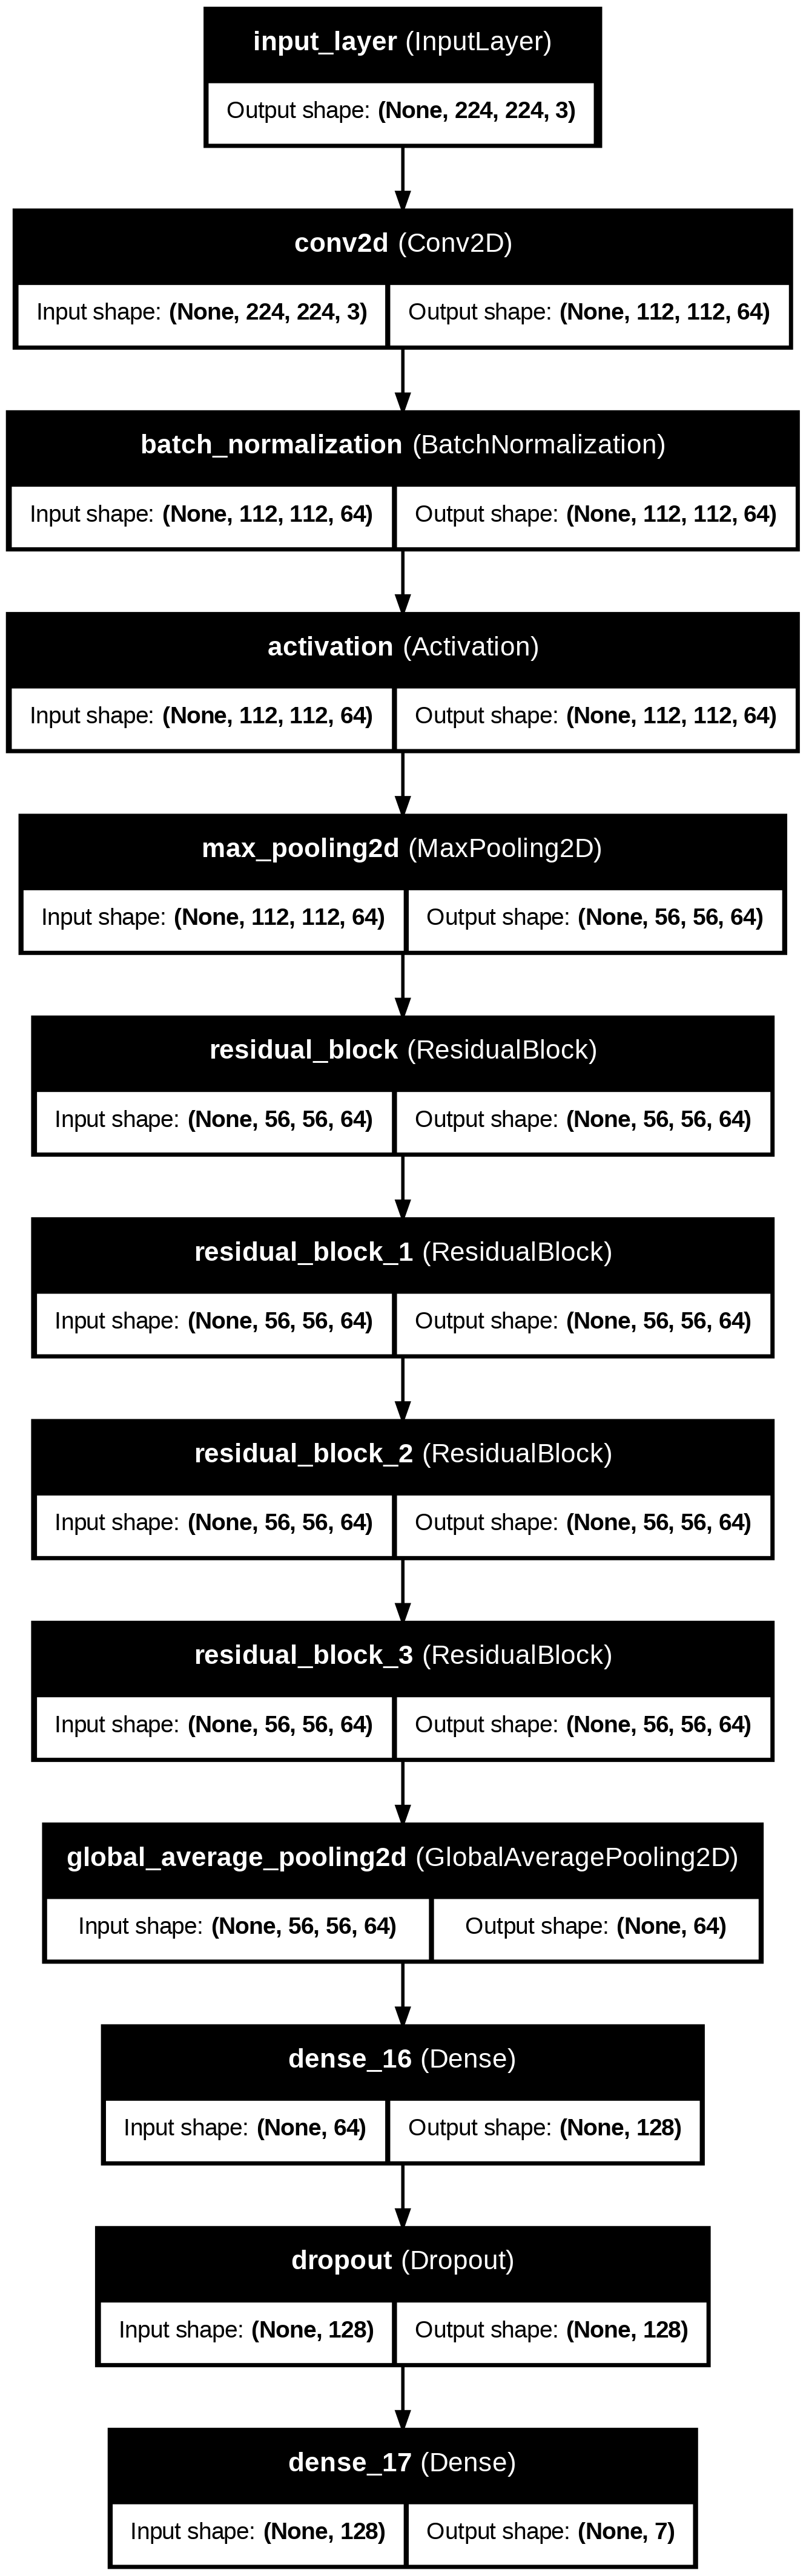

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is the Enhanced Residual Network defined in the previous code
plot_model(model, to_file='enhanced_residual_network.png', show_shapes=True, show_layer_names=True, rankdir='TB')


